# View GCaMP mismatch regular and closed loop data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr, spearmanr
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns

In [4]:
RunTresholdDict = {'B3M1': 145, 'B3M2': 295, 'B3M3': 325, 'B2M4': 110, 'B2M5': 180}

In [5]:
GRAB_Reg_1 = pd.read_csv('G8_MMclosed_regular_session1.csv', dtype=dtype_dict)
GRAB_Reg_2 = pd.read_csv('G8_MMclosed_regular_session2.csv', dtype=dtype_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'G8_MMclosed_regular_session2.csv'

In [4]:
# Chaning event name to halt and making it so that its True when there is a halt
#GRAB_Reg_1.loc[:, 'event'] = GRAB_Reg_1['event'].replace({False: True, True: False})
GRAB_Reg_1.rename(columns = {'event': 'halt'}, inplace = True)
GRAB_MM_2.rename(columns = {'event': 'halt'}, inplace = True)


In [5]:
#Make sure the index provides inforamtion of seconds since start
GRAB_Reg_1.set_index('Seconds', inplace=True)
GRAB_MM_2.set_index('Seconds', inplace=True)
# Theres only photomotry information from 15 seconds due to bleaching
GRAB_Reg_1 = GRAB_Reg_1.loc[ GRAB_Reg_1.index>30]
GRAB_MM_2 = GRAB_MM_2.loc[ GRAB_MM_2.index>30]

In [6]:
#Check that the same mice are in the datsets
print(GRAB_Reg_1.mouseID.unique())
print(GRAB_MM_2.mouseID.unique())


['B2M6' 'B3M8' 'B3M7' 'B3M6' 'B3M4']
['B2M6' 'B3M8' 'B3M7' 'B3M6' 'B3M4']


Plotted traces for B2M6


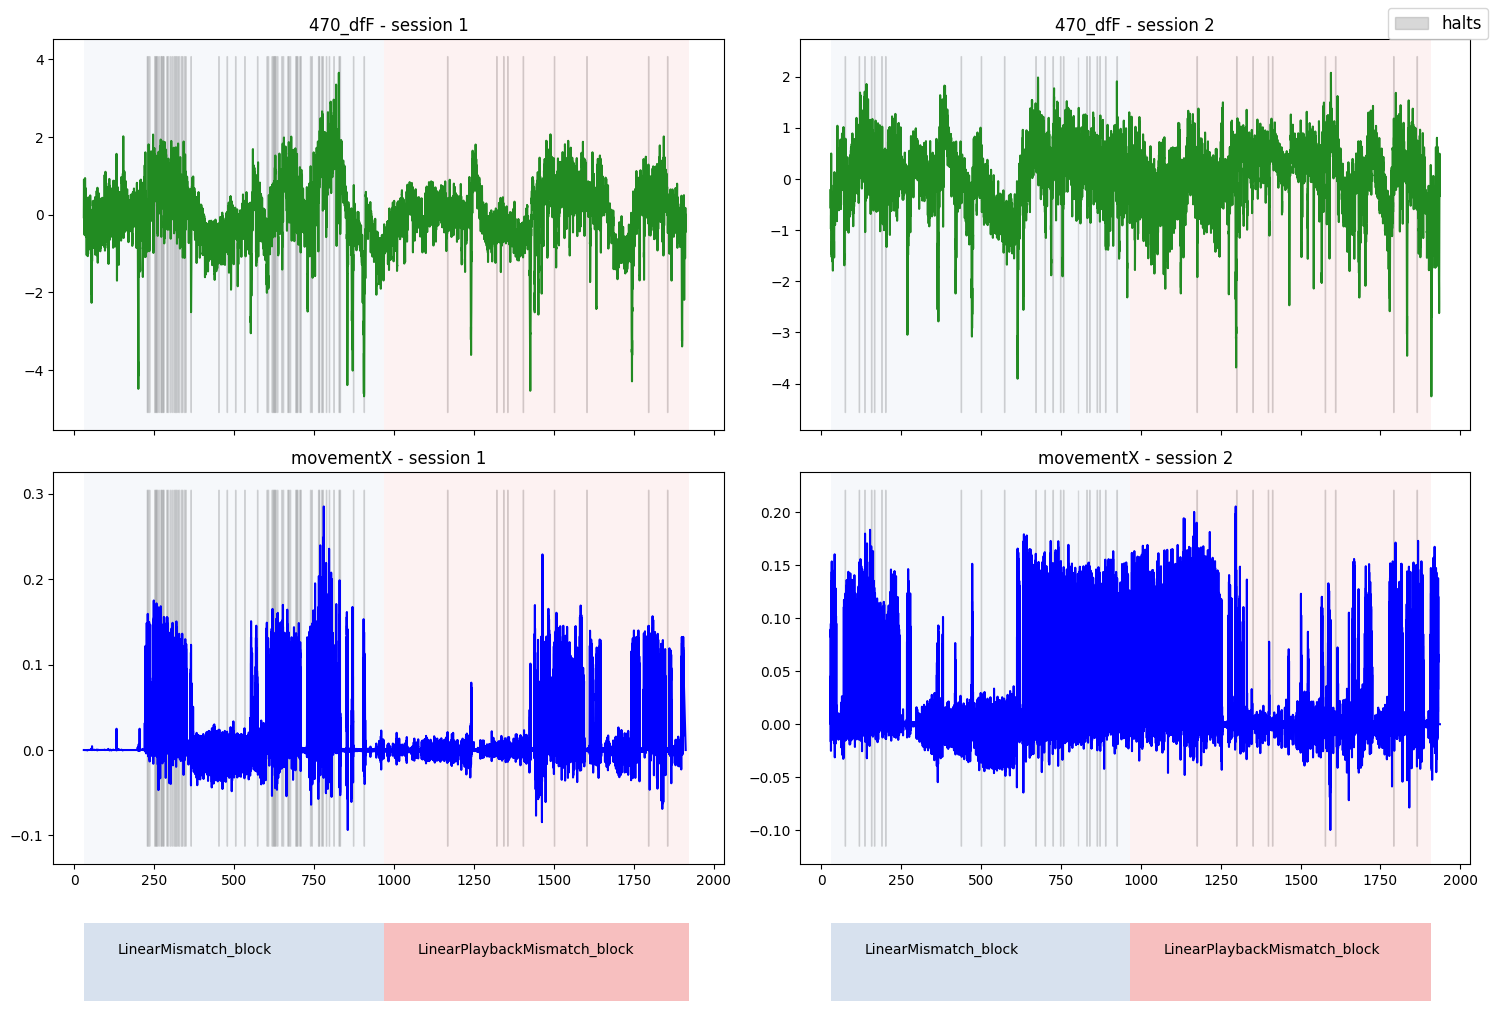

Plotted traces for B3M8


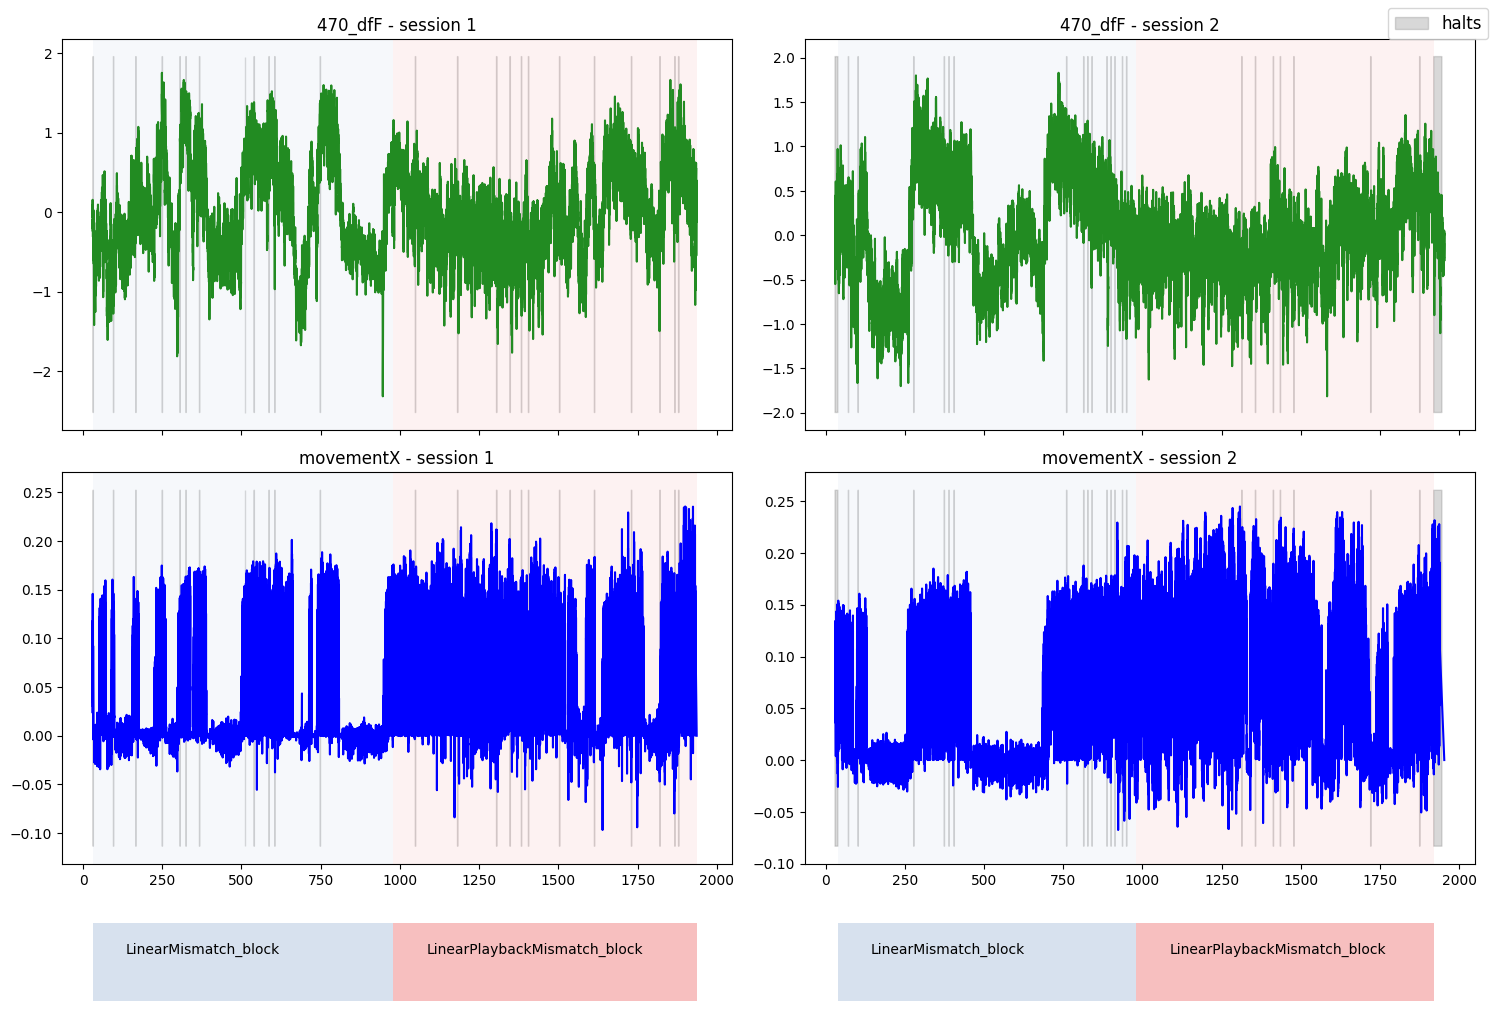

Plotted traces for B3M7


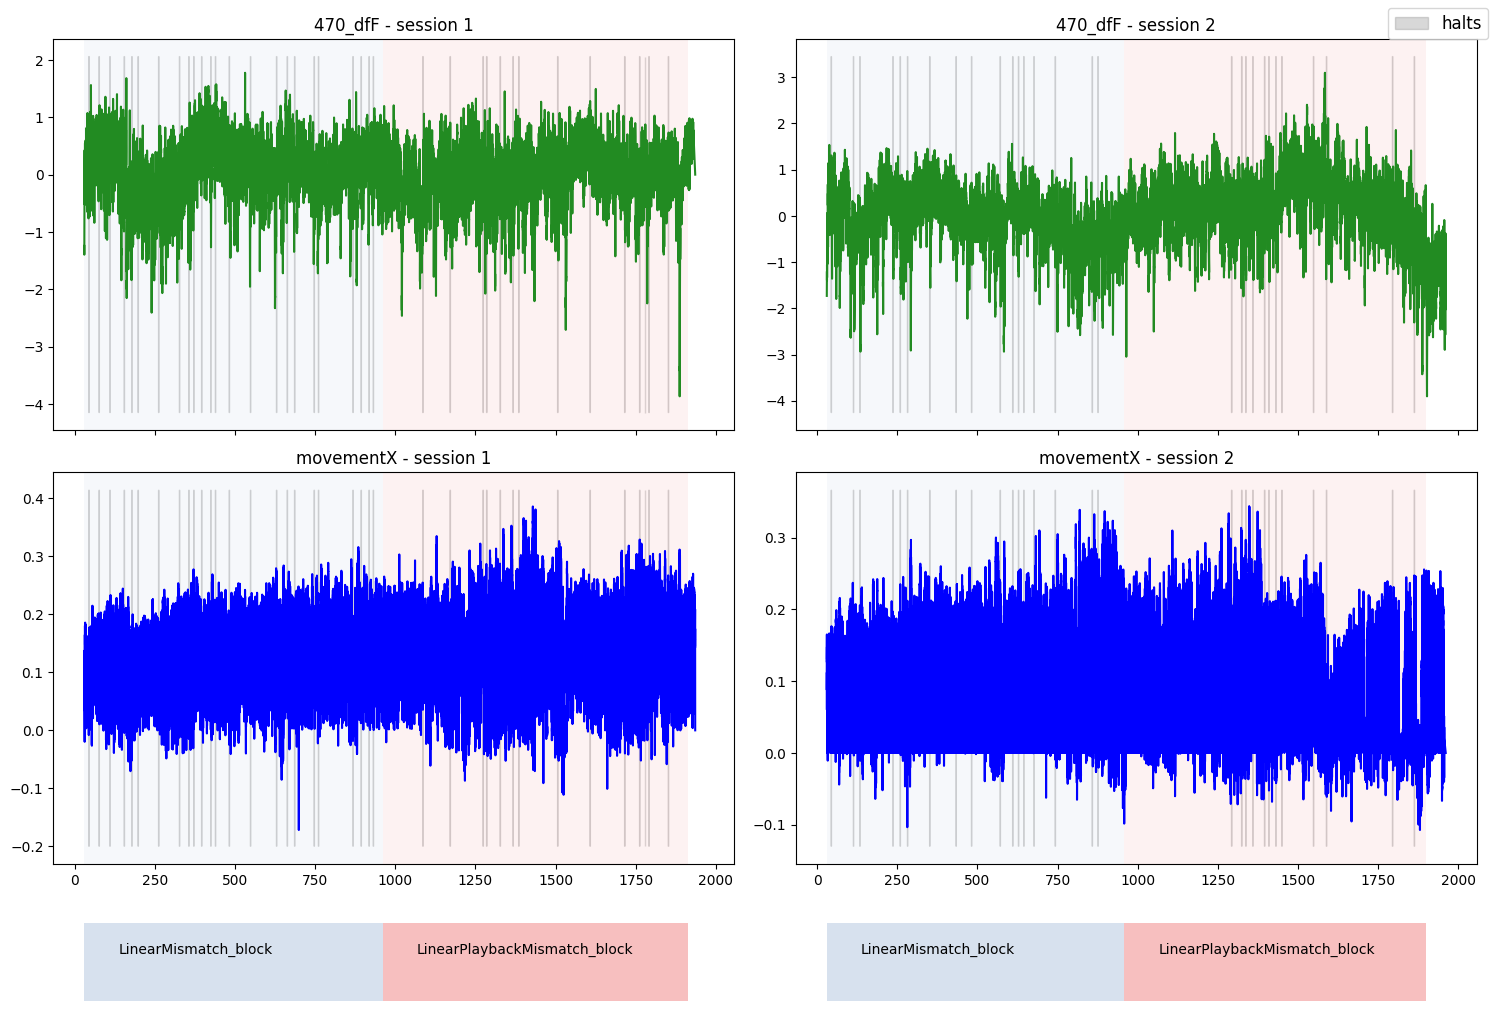

Plotted traces for B3M6


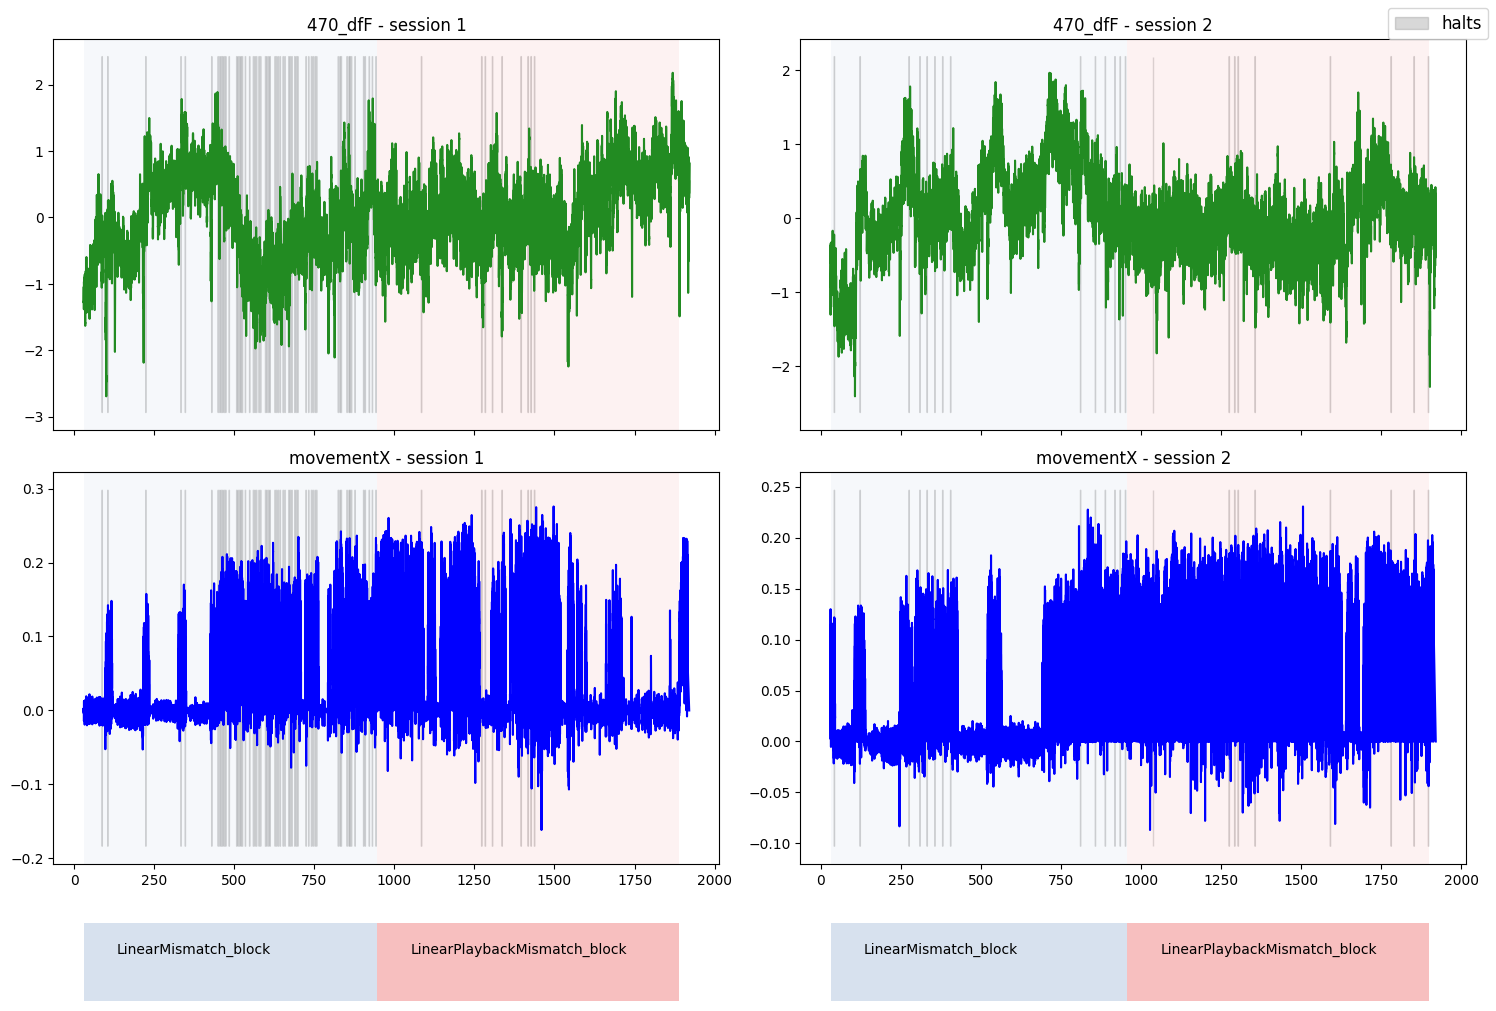

Plotted traces for B3M4


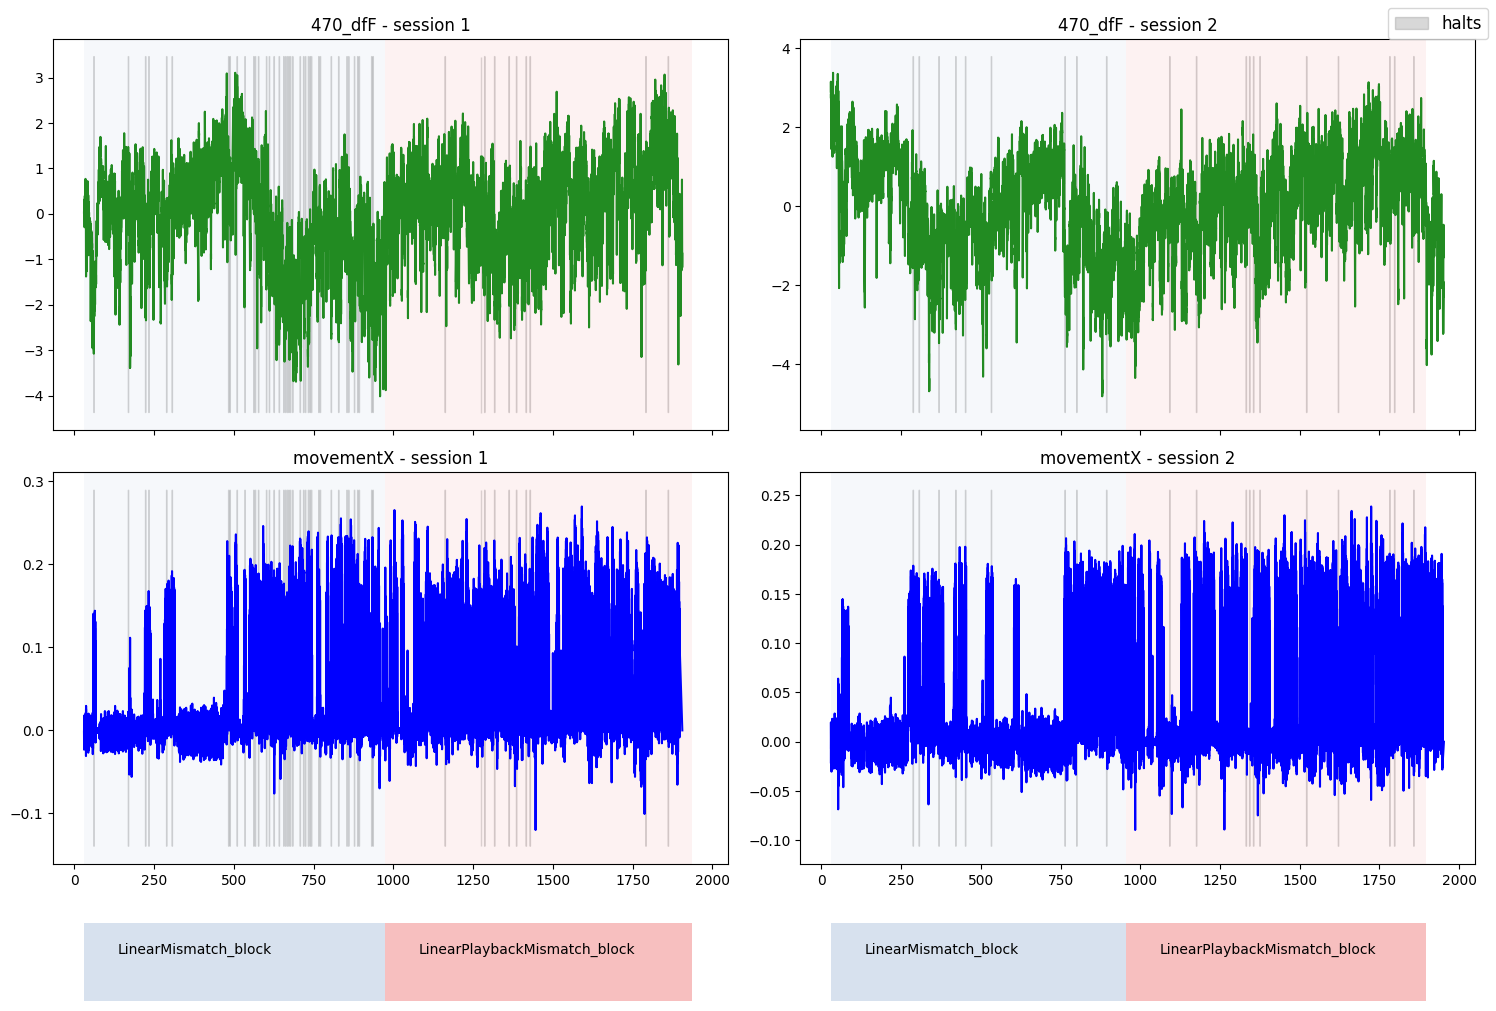

In [7]:
for mouse in GRAB_Reg_1.mouseID.unique():
    mousedata = {'session 1':GRAB_Reg_1.loc[GRAB_Reg_1.mouseID == mouse], 'session 2':GRAB_MM_2.loc[GRAB_MM_2.mouseID == mouse]}
    fig, ax = view_session_mouse(mousedata, mouse)
    fig.savefig(f'Figures/GRAB{mouse}_view_alignment.png', format = 'png', dpi = 300)

In [8]:
#Filter mice to get unique indexes
mouse_data = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for mouse in GRAB_Reg_1.mouseID.unique():
    mouse_data['session 1']['closedloop'][mouse] = filter_data(GRAB_Reg_1, filters = [mouse, 'closed_block'])
    mouse_data['session 1']['openloop'][mouse] = filter_data(GRAB_Reg_1, filters = [mouse, 'open_block'])
for mouse in GRAB_MM_2.mouseID.unique():
    mouse_data['session 2']['closedloop'][mouse] = filter_data(GRAB_MM_2, filters = [mouse, 'closed_block'])
    mouse_data['session 2']['openloop'][mouse] = filter_data(GRAB_MM_2, filters = [mouse, 'open_block'])

In [9]:
GRAB_Reg_1

470_dfF  movementX     movementY   halt ExperimentEvents  \
Seconds                                                               
30.001   -0.068699   0.000000  0.000000e+00  False              NaN   
30.002   -0.064503   0.000000  0.000000e+00  False              NaN   
30.003   -0.060307   0.000000  0.000000e+00  False              NaN   
30.004   -0.056110   0.000000  0.000000e+00  False              NaN   
30.005   -0.051914   0.000000  0.000000e+00  False              NaN   
...            ...        ...           ...    ...              ...   
1906.025 -0.884256   0.000046 -1.310201e-05  False              NaN   
1906.026 -0.882351   0.000034 -9.608143e-06  False              NaN   
1906.027 -0.880446   0.000021 -6.114273e-06  False              NaN   
1906.028 -0.878541   0.000009 -2.620403e-06  False              NaN   
1906.029 -0.877303   0.000001 -3.493870e-07  False              NaN   

                 Experiment Session mouseID sex area  No_halt  \
Seconds                                                         
30.001    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.002    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.003    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.004    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.005    MMclosed-and-open    day1    B2M6   M  V2M    False   
...                     ...     ...     ...  ..  ...      ...   
1906.025  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.026  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.027  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.028  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.029  MMclosed-and-open    day1    B3M4   M  V2M    False   

          LinearMismatch_block  LinearPlaybackMismatch_block  
Seconds                                                       
30.001                    True                         False  
30.002                    True                         False  
30.003                    True                         False  
30.004                    True                         False  
30.005                    True                         False  
...                        ...                           ...  
1906.025                 False                         False  
1906.026                 False                         False  
1906.027                 False                         False  
1906.028                 False                         False  
1906.029                 False                         False  

[9462049 rows x 13 columns]

In [10]:
def align_to_event_start(df, trace, event_col, range_around_event):
    
    trace_chunk_list = []
    bsl_trace_chunk_list = []
    run_speed_list = []
    turn_speed_list = []
    event_index_list = []
    
    # Identify the start times for each event
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index

    # Calculate the time range around each event
    before_0 = range_around_event[0]
    after_0 = range_around_event[1]
    
    # Calculate the target length of each chunk based on the sampling rate
    sampling_rate = 0.001
    target_length = int(((before_0 + after_0) / sampling_rate) + 1)  # Include both ends
    Index= pd.Series(np.linspace(-range_around_event[0], range_around_event[1], target_length)) # common index
    
    for event_time in event_times:
        
        # Determine the time range for each chunk
        start = event_time - before_0
        end = event_time + after_0
        
        # Extract the chunk from the trace column
        chunk = df[trace].loc[start:end]
        runspeed = df['movementX'].loc[start:event_time].mean() #Saving mean run speed up until halt
        turningspeed = df['movementY'].loc[start:event_time].mean() 
        # Normalize the index to start at -before_0
        chunk.index = (chunk.index - chunk.index[0]) - before_0
        # Check if the chunk is shorter than the target length
        if len(chunk) < target_length:
            # Pad the chunk with NaN values at the end to reach the target length
            padding = pd.Series([np.nan] * (target_length - len(chunk)), index=pd.RangeIndex(len(chunk), target_length))
            chunk = pd.concat([chunk, padding])
            chunk.index = Index # Getting the same index as the others
        
        # Baseline the chunk
        baselined_chunk = baseline(chunk)
        
        # Append the chunk and baselined chunk to lists
        trace_chunk_list.append(chunk.values)
        bsl_trace_chunk_list.append(baselined_chunk.values)
        run_speed_list.append(runspeed)
        turn_speed_list.append(turningspeed)
        event_index_list.append(event_time)  # Store the event time for use in final column names
    # Convert lists of arrays to DataFrames
    try:
        trace_chunks = pd.DataFrame(np.column_stack(trace_chunk_list), columns=event_index_list)
        bsl_trace_chunks = pd.DataFrame(np.column_stack(bsl_trace_chunk_list), columns=event_index_list)
        run_speeds = pd.DataFrame(np.column_stack(run_speed_list), columns=event_index_list)
        turn_speeds = pd.DataFrame(np.column_stack(turn_speed_list), columns=event_index_list)
        movement_speeds = pd.concat([run_speeds, turn_speeds])
        
        # Set the index as the common time range index for each chunk
        trace_chunks.index = Index
        bsl_trace_chunks.index = Index
        movement_speeds.index = ['Mean_moveX', 'Mean_moveY'] #set X and Y movement as movement speed index
        
        return trace_chunks, bsl_trace_chunks, movement_speeds
    
    except ValueError:
        if len(event_times) < 1:
            print('could not align to events because there were none, will return nothing')
            
        return 0, 0, 0


In [11]:
#Aligning open and closed loop block data to halt start times
mouse_aligned = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
move_speeds = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'halt',[1,2])
            mouse_aligned[session][block][mouse]  = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds[session][block][mouse]  = run_speeds
    

In [12]:
print(move_speeds['session 1']['closedloop']['B3M7'])
mouse_aligned['session 1']['closedloop']['B3M7']

             43.789    75.939    109.689   154.422   178.122   197.622  \
Mean_moveX  0.106941  0.139837  0.166962  0.123330  0.152199  0.076448   
Mean_moveY  0.007968  0.013292  0.019759  0.016609  0.015693  0.009419   

             261.621   326.554   355.820   371.237  ...   548.069   629.301  \
Mean_moveX  0.100420  0.112415  0.119973  0.220358  ...  0.121421  0.232719   
Mean_moveY  0.012128  0.011722  0.015663  0.026879  ...  0.017155  0.026278   

             662.851   685.668   746.767   760.084   867.733   893.266  \
Mean_moveX  0.190492  0.151233  0.150015  0.191513  0.084917  0.142965   
Mean_moveY  0.028487  0.019171  0.019292  0.023272  0.008075  0.021317   

             917.932   931.249  
Mean_moveX  0.158100  0.161678  
Mean_moveY  0.010075  0.017006  

[2 rows x 24 columns]


43.789    75.939    109.689   154.422   178.122   197.622   261.621  \
-1.000 -0.086654 -0.508431 -0.669999  0.247920 -0.434553 -0.336673 -0.418722   
-0.999 -0.085069 -0.510639 -0.670240  0.246741 -0.438655 -0.332603 -0.421365   
-0.998 -0.083483 -0.512847 -0.670481  0.245561 -0.442757 -0.328533 -0.424009   
-0.997 -0.081897 -0.515055 -0.670722  0.244382 -0.446859 -0.324463 -0.426653   
-0.996 -0.080311 -0.517263 -0.670963  0.243203 -0.450961 -0.320393 -0.429297   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996  0.509958  0.388824  0.776725  0.075162  0.162077  0.537353  0.004731   
 1.997  0.513506  0.387261  0.779939  0.074263  0.158672  0.538437  0.007925   
 1.998  0.517054  0.385698  0.783152  0.073364  0.155268  0.539521  0.011120   
 1.999  0.520603  0.384134  0.786366  0.072465  0.151863  0.540605  0.014314   
 2.000  0.524151  0.382571  0.789580  0.071566  0.148459  0.541690  0.017509   

         326.554   355.820   371.237  ...   548.069   629.301   662.851  \
-1.000 -0.275159 -0.191602 -0.166684  ... -0.895260 -0.575729 -0.228851   
-0.999 -0.275913 -0.192074 -0.166628  ... -0.893032 -0.572356 -0.223028   
-0.998 -0.276668 -0.192546 -0.166572  ... -0.890803 -0.568984 -0.217205   
-0.997 -0.277422 -0.193019 -0.166516  ... -0.888575 -0.566617 -0.211383   
-0.996 -0.278176 -0.193491 -0.166460  ... -0.886346 -0.566728 -0.205560   
...          ...       ...       ...  ...       ...       ...       ...   
 1.996  0.417433  0.328932  0.822173  ...  1.026070  0.280993  0.256884   
 1.997  0.417453  0.331958  0.819606  ...  1.024218  0.279486  0.259645   
 1.998  0.417472  0.334984  0.816864  ...  1.022366  0.277979  0.262406   
 1.999  0.417492  0.338010  0.814113  ...  1.020513  0.276473  0.265168   
 2.000  0.417512  0.341035  0.811363  ...  1.018661  0.274966  0.267929   

         685.668   746.767   760.084   867.733   893.266   917.932   931.249  
-1.000 -0.423006 -0.716960 -0.182002  0.418605 -0.319545 -0.435551 -0.912280  
-0.999 -0.423124 -0.713914 -0.178059  0.416097 -0.321367 -0.434524 -0.912847  
-0.998 -0.423242 -0.710867 -0.174116  0.413590 -0.323188 -0.433498 -0.913414  
-0.997 -0.423359 -0.707821 -0.170172  0.411082 -0.325010 -0.432471 -0.913981  
-0.996 -0.423477 -0.704774 -0.166303  0.408574 -0.326832 -0.431444 -0.914548  
...          ...       ...       ...       ...       ...       ...       ...  
 1.996  0.922937  0.121752  1.010795  0.644057  0.647009  0.825122  0.554401  
 1.997  0.921950  0.122997  1.010705  0.645624  0.647229  0.827111  0.553019  
 1.998  0.920964  0.124242  1.010614  0.647190  0.647450  0.829099  0.551636  
 1.999  0.919978  0.125487  1.010523  0.648757  0.647670  0.831088  0.550254  
 2.000  0.918991  0.126732  1.010433  0.650323  0.647891  0.833076  0.548871  

[3001 rows x 24 columns]

In [13]:
len(mouse_aligned['session 1']['closedloop'].keys())

5

In [14]:
mouse_aligned_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
move_speeds_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}
for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'No_halt',[1,2])
            mouse_aligned_nohalt[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds_nohalt[session][block][mouse]  = run_speeds

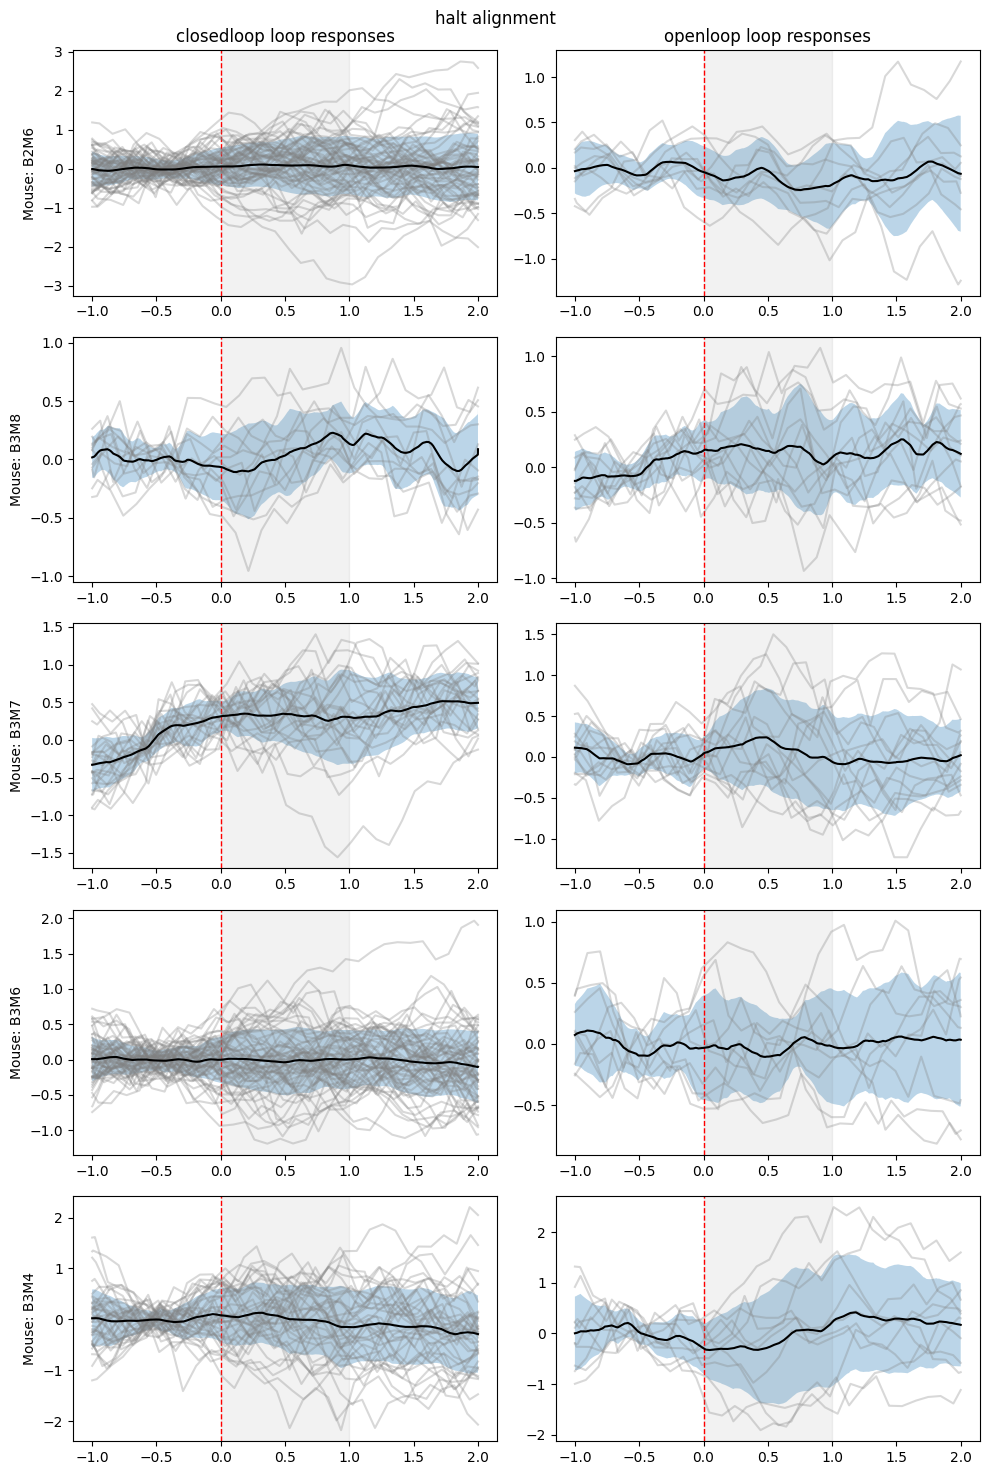

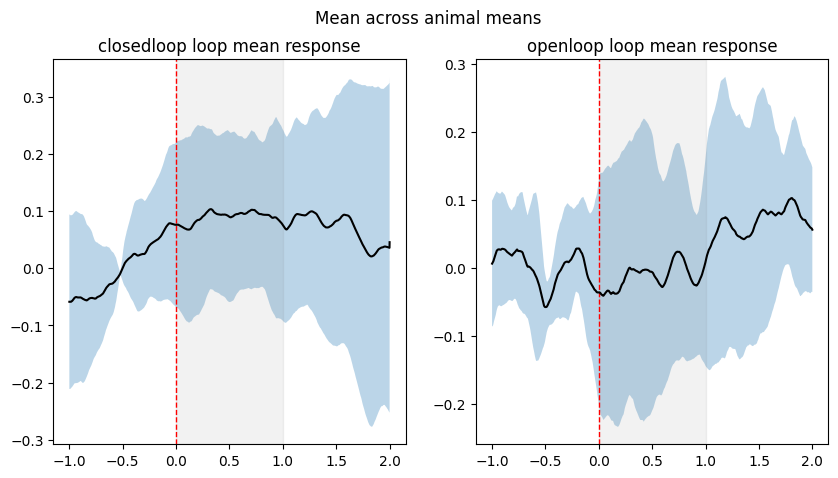

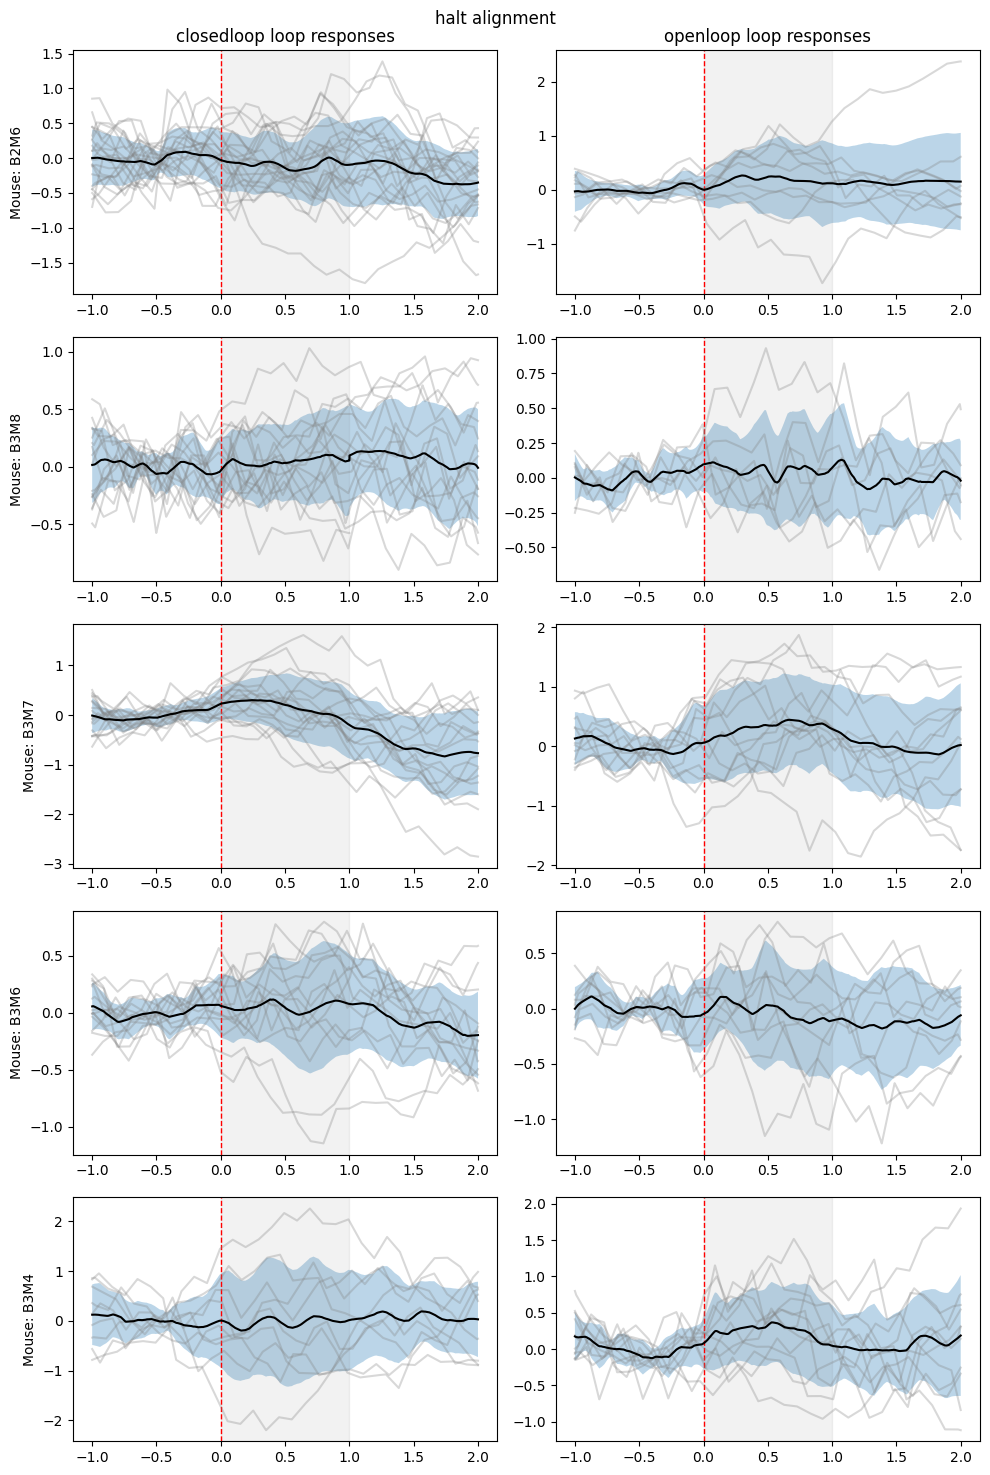

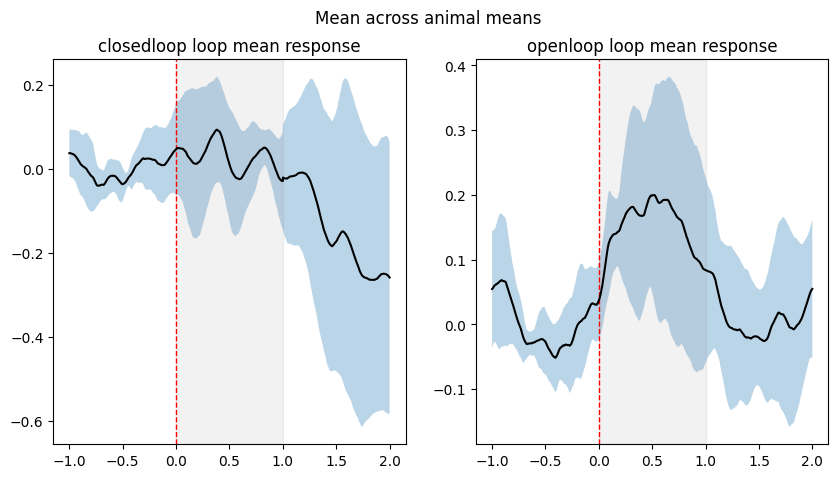

In [15]:
mean_mouse_dict_s1 =plot_compare_blocks(mouse_aligned['session 1'], 'halt')
mean_mouse_dict_s2 =plot_compare_blocks(mouse_aligned['session 2'], 'halt')

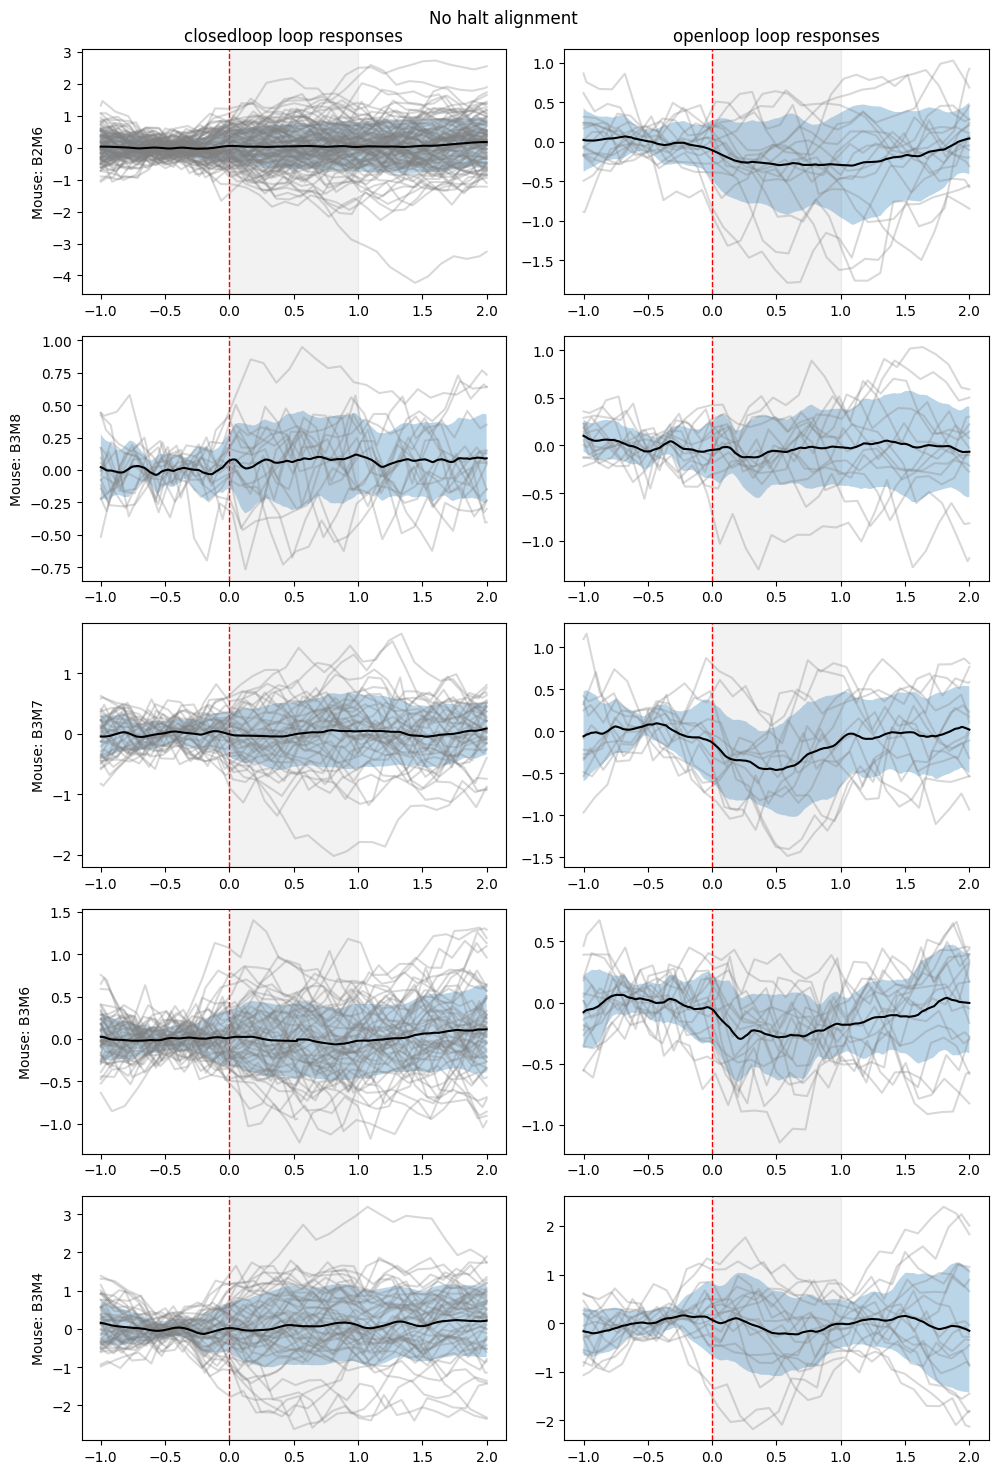

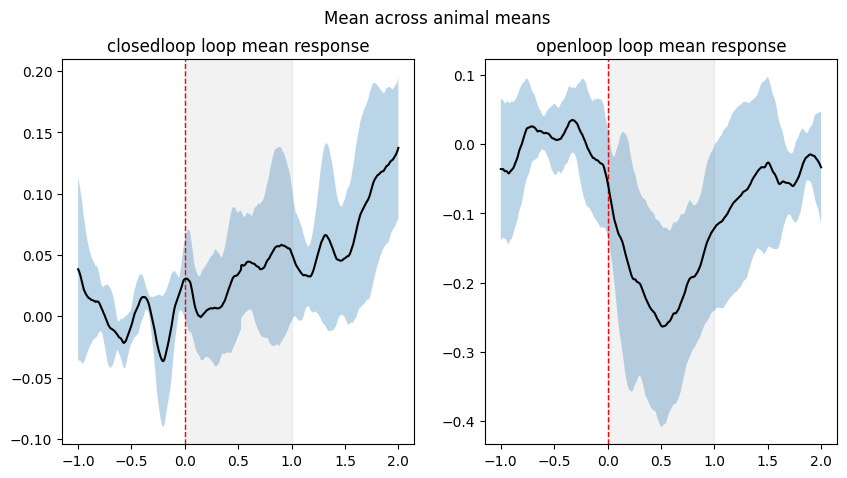

In [16]:
mean_mouse_dict_s1_nohalt =plot_compare_blocks(mouse_aligned_nohalt['session 1'], 'No halt')

In [17]:
mouse_aligned['session 1']['closedloop'].keys()

dict_keys(['B2M6', 'B3M8', 'B3M7', 'B3M6', 'B3M4'])

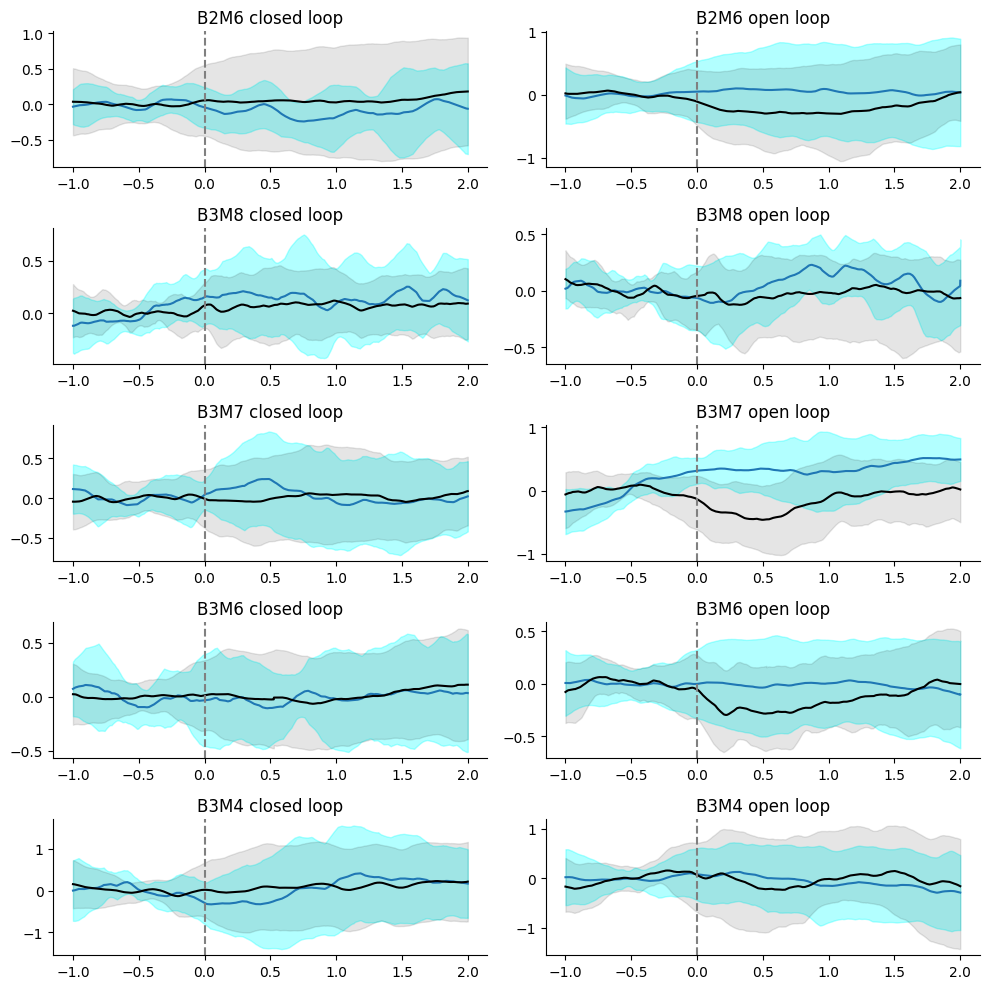

In [18]:
fig, axes = plt.subplots(len(mouse_aligned['session 1']['closedloop']),2, figsize = (10,10))
axes = axes.flatten()
i = 0
for (mouse_open, alinged_data_open), (mouse, alinged_data_closed) in zip(mouse_aligned['session 1']['closedloop'].items(), mouse_aligned['session 1']['openloop'].items()):
    ax = axes[i]
    ax.spines[['right', 'top']].set_visible(False)
    #Get no-halt trace
    aligned_nohalt = mouse_aligned_nohalt['session 1']['closedloop'][mouse]

    #Getting mean and standard devaiton
    mouse_data_mean = alinged_data_closed.mean(axis=1)
    mouse_data_std = alinged_data_closed.std(axis=1)
    mouse_nohalt_mean = aligned_nohalt.mean(axis=1)
    mouse_nohalt_std = aligned_nohalt.std(axis=1)

    #Plot main trace 
    ax.plot(mouse_data_mean)
    ax.fill_between(mouse_data_mean.index, mouse_data_mean+mouse_data_std, mouse_data_mean-mouse_data_std, color='cyan', alpha=0.3)
    #plot control trace
    control_trace = ax.plot(mouse_nohalt_mean, color = 'black', label = 'control')
    ax.fill_between(mouse_nohalt_mean.index, mouse_nohalt_mean+mouse_nohalt_std, 
                       mouse_nohalt_mean-mouse_nohalt_std, color='black', alpha=0.1)
    ax.set_title(f'{mouse} closed loop')
    ax.axvline(0, c='grey', ls= '--')
    i+=1
    ax = axes[i]
    ax.spines[['right', 'top']].set_visible(False)
    #Get no-halt trace for open loop
    aligned_nohalt_o = mouse_aligned_nohalt['session 1']['openloop'][mouse]

    #Getting mean and standard devaiton
    mouse_data_mean = alinged_data_open.mean(axis=1)
    mouse_data_std = alinged_data_open.std(axis=1)
    mouse_nohalt_o_mean = aligned_nohalt_o.mean(axis=1)
    mouse_nohalt_o_std = aligned_nohalt_o.std(axis=1)

    #Plot main trace 
    ax.plot(mouse_data_mean)
    ax.fill_between(mouse_data_mean.index, mouse_data_mean+mouse_data_std, mouse_data_mean-mouse_data_std, color='cyan', alpha=0.3)
    #plot control trace
    control_trace = ax.plot(mouse_nohalt_o_mean, color = 'black', label = 'control')
    ax.fill_between(mouse_nohalt_o_mean.index, mouse_nohalt_o_mean+mouse_nohalt_std, 
                       mouse_nohalt_o_mean-mouse_nohalt_o_std, color='black', alpha=0.1)
    ax.set_title(f'{mouse} open loop')
    ax.axvline(0, c='grey', ls= '--')
    i+=1
fig.tight_layout(pad=1.08)

    
    


In [19]:
sessions = mouse_aligned.keys()

In [20]:
'Mean_moveX' in move_speeds['session 1']['openloop']['B3M7'].index

True

In [21]:
def extract_aligned_vars(aligned_data_dict, aligned_movement_dict):
    # Initialize an empty list to store results
    results = []
    
    for session_number, session_blocks in aligned_data_dict.items():
        for session_block, mice_data in session_blocks.items():
            for mouse_id, item in mice_data.items():
                run_df = aligned_movement_dict[session_number][session_block][mouse_id]
                # Check if the item is a DataFrame
                if not isinstance(item, pd.DataFrame):
                    print(f"Warning: The data for Mouse ID '{mouse_id}' in session '{session_number}' and block '{session_block}' is not a DataFrame. Skipping.")
                    continue

                # Copy the DataFrame and ensure the index is numeric
                df = item.copy()
                df.index = pd.to_numeric(df.index)

                # Process each column independently
                for column in df.columns:
                    event_time_data = df.loc[0:1, column]  # Data during the event (0 to +1 seconds)
                    post_event_data = df.loc[1:2, column]  # Data during the first second after the event (+1 to +2 seconds)

                    peak_response = event_time_data.max()  # Max response during the event
                    min_response = event_time_data.min()  # Minimum response during the event
                    mean_response_event = event_time_data.mean()  # Mean response during the event
                    mean_response_post_event = post_event_data.mean()  # Mean response during the post-event time
                    min_response_post_event = post_event_data.min()  #Minimum response during the post-event time
                    peak_response_post_event = post_event_data.max() #Maximum response during the post-event time

                    #Given Mean_moveX and Y being the row names in the movement df, the 1 second pre halt movement speeds are added
                    x_move = run_df.loc['Mean_moveX', column]
                    y_move = run_df.loc['Mean_moveY', column]
    
                    #add results to list of dicts
                    results.append({
                        "SessionNumber": session_number,
                        "SessionBlock": session_block,
                        "MouseID": mouse_id,
                        "EventTime": column,
                        "moveX": x_move,
                        "moveY": y_move,
                        "PeakResponse": peak_response,
                        "MinResponse":  min_response,
                        "MeanResponse": mean_response_event,
                        "MeanResponse_after": mean_response_post_event,
                        "MinResponse_after": min_response_post_event,
                        "PeakResponse_after": peak_response_post_event,
                    })

    # convert to a pandas df
    output_df = pd.DataFrame(results)
    return output_df



In [22]:
extracted_variables = extract_aligned_vars(mouse_aligned, move_speeds)


In [23]:
extracted_variables 

SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
0       session 1   closedloop    B2M6    228.563  0.064001  0.004655   
1       session 1   closedloop    B2M6    231.212  0.057154  0.007068   
2       session 1   closedloop    B2M6    235.679  0.062974  0.007640   
3       session 1   closedloop    B2M6    251.729  0.065576  0.010835   
4       session 1   closedloop    B2M6    254.596  0.067306  0.013628   
..            ...          ...     ...        ...       ...       ...   
373     session 2     openloop    B3M4   1521.463  0.094923  0.017975   
374     session 2     openloop    B3M4   1621.145  0.000462  0.000474   
375     session 2     openloop    B3M4   1782.343  0.136651  0.024435   
376     session 2     openloop    B3M4   1797.293  0.089015  0.016419   
377     session 2     openloop    B3M4   1857.509  0.104698  0.019968   

     PeakResponse  MinResponse  MeanResponse  MeanResponse_after  \
0        0.177466    -0.410383     -0.133882           -0.108918   
1        0.541006    -0.453093      0.044481            1.620640   
2        1.463309     0.254507      0.990582            1.000354   
3        0.351772    -0.377490      0.071803            0.096018   
4        0.691368    -0.018639      0.407037           -0.003151   
..            ...          ...           ...                 ...   
373      1.150399    -0.505200      0.442276           -0.307164   
374      0.008770    -0.481050     -0.240955           -0.326373   
375      1.080995     0.226328      0.598638           -0.259448   
376     -0.116898    -0.961239     -0.606934           -0.293653   
377      1.515718     0.564865      1.006747            1.080183   

     MinResponse_after  PeakResponse_after  
0            -0.532615            0.181976  
1             0.305605            2.293492  
2             0.517900            1.942020  
3            -0.210416            0.315586  
4            -0.379283            0.418986  
..                 ...                 ...  
373          -0.946864            0.752610  
374          -0.653547           -0.107295  
375          -1.117650            0.562072  
376          -0.943956            0.307099  
377           0.410124            1.934183  

[378 rows x 12 columns]

In [24]:
extracted_variables_nohalt = extract_aligned_vars(mouse_aligned_nohalt, move_speeds_nohalt)


In [25]:
extracted_variables_nohalt['event']='no halt'
extracted_variables['event']='halt'
combined_vars = pd.concat([extracted_variables_nohalt, extracted_variables])

combined_vars.to_csv('GRAB_MM_extracted_vars.csv', index=False)

In [36]:
##Consider adding to the fitted model a continous variable which is the time column
#EventTime should currently be seconds from session start

# Look for correlation between running and fluorescence changes

In [37]:
GRAB_Reg_1

470_dfF  movementX     movementY   halt ExperimentEvents  \
Seconds                                                               
30.001   -0.068699   0.000000  0.000000e+00  False              NaN   
30.002   -0.064503   0.000000  0.000000e+00  False              NaN   
30.003   -0.060307   0.000000  0.000000e+00  False              NaN   
30.004   -0.056110   0.000000  0.000000e+00  False              NaN   
30.005   -0.051914   0.000000  0.000000e+00  False              NaN   
...            ...        ...           ...    ...              ...   
1906.025 -0.884256   0.000046 -1.310201e-05  False              NaN   
1906.026 -0.882351   0.000034 -9.608143e-06  False              NaN   
1906.027 -0.880446   0.000021 -6.114273e-06  False              NaN   
1906.028 -0.878541   0.000009 -2.620403e-06  False              NaN   
1906.029 -0.877303   0.000001 -3.493870e-07  False              NaN   

                 Experiment Session mouseID sex area  No_halt  \
Seconds                                                         
30.001    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.002    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.003    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.004    MMclosed-and-open    day1    B2M6   M  V2M    False   
30.005    MMclosed-and-open    day1    B2M6   M  V2M    False   
...                     ...     ...     ...  ..  ...      ...   
1906.025  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.026  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.027  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.028  MMclosed-and-open    day1    B3M4   M  V2M    False   
1906.029  MMclosed-and-open    day1    B3M4   M  V2M    False   

          LinearMismatch_block  LinearPlaybackMismatch_block  
Seconds                                                       
30.001                    True                         False  
30.002                    True                         False  
30.003                    True                         False  
30.004                    True                         False  
30.005                    True                         False  
...                        ...                           ...  
1906.025                 False                         False  
1906.026                 False                         False  
1906.027                 False                         False  
1906.028                 False                         False  
1906.029                 False                         False  

[9462049 rows x 13 columns]

In [87]:
subset = filter_data(GRAB_Reg_1, ['B3M7', 'day1'])

In [88]:
subset

470_dfF  movementX  movementY   halt ExperimentEvents  \
Seconds                                                            
30.001   -1.243130   0.107249  -0.008689  False              NaN   
30.002   -1.245231   0.106711  -0.008946  False              NaN   
30.003   -1.247331   0.106174  -0.009203  False              NaN   
30.004   -1.249432   0.105636  -0.009459  False              NaN   
30.005   -1.251533   0.105098  -0.009716  False              NaN   
...            ...        ...        ...    ...              ...   
1935.441  0.000500   0.002584  -0.000591  False              NaN   
1935.442  0.000370   0.001913  -0.000437  False              NaN   
1935.443  0.000240   0.001242  -0.000284  False              NaN   
1935.444  0.000110   0.000570  -0.000130  False              NaN   
1935.445  0.000019   0.000101  -0.000023  False              NaN   

                 Experiment Session mouseID sex area  No_halt  \
Seconds                                                         
30.001    MMclosed-and-open    day1    B3M7   F  V2M    False   
30.002    MMclosed-and-open    day1    B3M7   F  V2M    False   
30.003    MMclosed-and-open    day1    B3M7   F  V2M    False   
30.004    MMclosed-and-open    day1    B3M7   F  V2M    False   
30.005    MMclosed-and-open    day1    B3M7   F  V2M    False   
...                     ...     ...     ...  ..  ...      ...   
1935.441  MMclosed-and-open    day1    B3M7   F  V2M    False   
1935.442  MMclosed-and-open    day1    B3M7   F  V2M    False   
1935.443  MMclosed-and-open    day1    B3M7   F  V2M    False   
1935.444  MMclosed-and-open    day1    B3M7   F  V2M    False   
1935.445  MMclosed-and-open    day1    B3M7   F  V2M    False   

          LinearMismatch_block  LinearPlaybackMismatch_block  
Seconds                                                       
30.001                    True                         False  
30.002                    True                         False  
30.003                    True                         False  
30.004                    True                         False  
30.005                    True                         False  
...                        ...                           ...  
1935.441                 False                         False  
1935.442                 False                         False  
1935.443                 False                         False  
1935.444                 False                         False  
1935.445                 False                         False  

[1905445 rows x 13 columns]

In [89]:
# Compute Pearson correlation
pearson_corr, pearson_pval = pearsonr(subset['movementX'], subset['470_dfF'])

# Compute Spearman correlation (handles nonlinear relationships better)
spearman_corr, spearman_pval = spearmanr(subset['movementX'], subset['470_dfF'])

print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")

Pearson correlation: 0.1977993512929279, p-value: 0.0
Spearman correlation: 0.17545703670027873, p-value: 0.0


In [63]:
resampled = subset.sample(10000, random_state=9)  # Sample 10,000 rows
pearson_corr, pearson_pval = pearsonr(resampled['movementX'], resampled['470_dfF'])
spearman_corr, spearman_pval = spearmanr(resampled['movementX'], resampled['470_dfF'])
print(f"Subset Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
print(f"Subset Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")

Subset Pearson correlation: 0.32780978418428447, p-value: 3.763733012830786e-249
Subset Spearman correlation: 0.3752697586544597, p-value: 0.0


In [30]:
import numpy as np
from scipy.stats import bootstrap

#data = np.array([GRAB_Reg_1['movementX'], GRAB_Reg_1['470_dfF']]).T
#ci = bootstrap((data,), np.corrcoef, confidence_level=0.95, n_resamples=1000)
#print(f"95% Confidence Interval for Pearson correlation: {ci.confidence_interval}")
